# Text cluster analysis

In [1]:
#Uncomment this for installing the needed libraries.
#pip install wordcloud 
#(if issues with wordcloud installation, follow the steps here: https://stackoverflow.com/questions/64261546/how-to-solve-error-microsoft-visual-c-14-0-or-greater-is-required-when-inst)
#it is easier to install Anaconda and install it on anaconda conda install -c conda-forge wordcloud

#pip install pandas
#pip install sklearn
#pip install matplotlib
#pip install numpy

In [2]:
import pandas as pd
from wordcloud import WordCloud
import pathlib
import re

In [3]:
PATH =  f'{pathlib.Path().absolute()}\Musical_instruments_reviews.csv'
column_name__open_responses = 'reviewText'
language = 'english'

In [4]:
df = pd.read_csv(PATH)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


### Text cluster analysis

Taken from https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d



#### Fetch responses

First let's evaluate if there are null values in open ended responses.

In [5]:
print(df[column_name__open_responses].isna().sum())

0


Depending on the number of null answers, we just may drop them.

In [6]:
df = df.dropna(subset=[column_name__open_responses])
df = df.reset_index(drop=True)

In [7]:
print(df[column_name__open_responses].isna().sum())

0


Now let's remove non-alphanumeric characters.

In [8]:
pattern = re.compile('\W')
df[column_name__open_responses].apply(lambda x: re.sub(pattern, ' ', x))

0      Not much to write about here  but it does exac...
1      The product does exactly as it should and is q...
2      The primary job of this device is to block the...
3      Nice windscreen protects my MXL mic and preven...
4      This pop filter is great  It looks and perform...
                             ...                        
494    does what is designed to do easy to use seems ...
495    If you play 12 acoustic you gotta get this one...
496    This capo does exactly what it should   It cla...
497    This is for theKyser Banjo Mandolin CapoThis i...
498    works great  stays out of the way    cant ask ...
Name: reviewText, Length: 499, dtype: object

In [9]:
responses = df[column_name__open_responses]
responses

0      Not much to write about here, but it does exac...
1      The product does exactly as it should and is q...
2      The primary job of this device is to block the...
3      Nice windscreen protects my MXL mic and preven...
4      This pop filter is great. It looks and perform...
                             ...                        
494    does what is designed to do easy to use seems ...
495    If you play 12 acoustic you gotta get this one...
496    This capo does exactly what it should.  It cla...
497    This is for theKyser Banjo/Mandolin CapoThis i...
498    works great, stays out of the way... cant ask ...
Name: reviewText, Length: 499, dtype: object

#### Represent each response as a vector

Since we are going to use k-means, we need to represent each article as a numeric vector. A popular method is to use term-frequency/inverse-document-frequency (tf-idf). TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. (For further info, please see https://monkeylearn.com/blog/what-is-tf-idf/)

It is recommended that common, stop words are excluded. All the calculations are easily done with sklearn’s TfidfVectorizer.

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={language})
X = vectorizer.fit_transform(responses)

#### Perform k-means clustering
Each row of variable X is a vector representation of a response. Hence, we can use X as input for the k-means algorithm.

First, we must decide on the number of clusters. Here, we will use the elbow and the silhouette score methods.

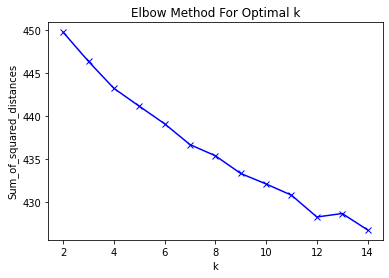

In [22]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,15)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

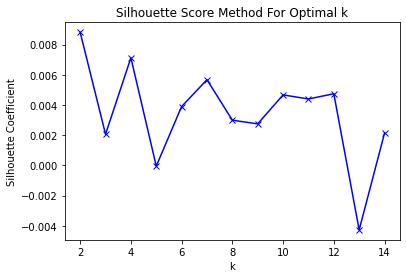

In [21]:
import matplotlib.pyplot as plt
silhouette_coeff = []
K = range(2,15)

for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    score = silhouette_score(X, km.labels_, metric='euclidean') 
    silhouette_coeff.append(score)

plt.plot(K, silhouette_coeff, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Coefficient')
plt.title('Silhouette Score Method For Optimal k')
plt.show()

#### Decide the best K

Besides the elbow and the silhouette score method, you may need to read how data is being clustered and name the clusters accordingly. For this case, I am going for 7 clusters.

In [23]:
true_k = 7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_

data = {
        column_name__open_responses: df[column_name__open_responses].tolist()
        , 'labels': labels
}
df_cl=pd.DataFrame(data)
df_cl.sort_values(by='labels')


,reviewText,labels
136,Hosa patch cables are the best for the buck. G...,0
28,The Hosa XLR cables are affordable and very he...,0
78,"Hosa makes good stuff, this is no exception. I...",0
62,Hosa guitar cables work great. Never had any p...,0
36,These are not the greatest but they're cheap a...,0
...,...,...
72,"This is your basic, black electric guitar cabl...",6
70,Hosa Cable GTR210 Guitar Instrument Cable - 10...,6
20,This is a cool looking cheap cable which works...,6
37,"This is a fine cable at a decent price point, ...",6


# Evaluate the result

A nice way to evaluate the clustering is to create a word cloud from the articles of each cluster.

Cluster: 0
reviewText
Cant go wrong. Great quality on a budget price ...
The Hosa XLR cables are affordable and very hea...
These are not the greatest but they're cheap an...
I've used a lot of cables and I always come bac...
I have found Hosa cables to be an excellent val...
This my second Hosa guitar cable.  (The other o...
Hosa guitar cables work great. Never had any pr...
Hosa makes good stuff, this is no exception. I'...
Good cable, as good as any expensive brand. Thi...
I own lots of hosa cables they are cheap and qu...
Another quality product from Hosa.  Just what I...
When I ordered these I wasn't expecting a whole...
When you need an audio insert cable, you need a...
These little patch cables work nicely, there's ...
Bought this Hosa Pedal Cable for our son to int...
Hosa patch cables are the best for the buck. Gr...
As expected from Hosa another great product.  S...


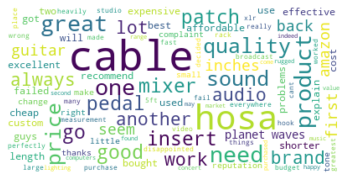

Cluster: 1
reviewText
I bought this to use in my home studio to contr...
This product does exactly what it is supposed t...
It is exactly what you need in a capo! You can ...
My son needed a Capo, expensive at music  shop ...
This Capo looks great and does the job. It does...
Purchased the 6-string Kyser capo when I meant ...
I've seen and used many different types of capo...
It is very well made, is easy to use, and holds...
       Durable, affordable, easy to grasp and use.
This capo is as good as I've ever used and its ...
Got what I needed - a basic capo for a good pri...
I've played guitar for 5 years. Seen many diffe...
The handle and spring strength make this uncomf...
What's to say?  It's not a high end capo and fo...
This style of capo CAN throw your guitar out of...
I can only repeat what everyone else has alread...
I don't believe there is such a thing as a perf...
I have used a few different capo's this is far ...
It does what it says. It a Kyser Quick Change c...
It's a ca

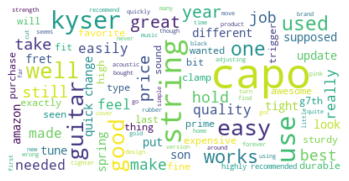

Cluster: 2
reviewText
Not much to write about here, but it does exact...
The product does exactly as it should and is qu...
This pop filter is great. It looks and performs...
I got it to have it if I needed it. I have foun...
I love it, I used this for my Yamaha ypt-230 an...
wanted it just on looks alone...It is a nice lo...
Very good cable. Well made and it looks great w...
Hosa products are a good bang for the buck. I h...
This cable seems like it will last me for a whi...
Zero issues with this cable so far.  It feels f...
Realtively inexpensive patch cable for electric...
This is a very nice cable for the price. I alre...
Seems sturdy enough, and no noise issues, so I'...
I'm not a professional, but have been playing f...
Works for practice ... it's a guitar instrument...
Good quality guitar cord.Very low noise, repair...
It's a cable, no frills, tangles pretty easy an...
One end was loose, so I tightened it, it keeps ...
Hard to day too much, but it works great. No is...
For the p

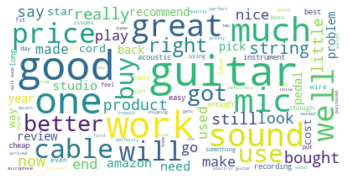

Cluster: 3
reviewText
I bought this to use with my keyboard. I wasn't...
This thing is like a magic Spray! Hah!Seriously...
I have a few Shure SM58s which cost more.  I li...
4 stars instead of 5 only because this thing wo...
It is so hard to get an honest review of any mi...
I started with the Shure PG58 and most recently...
This is the #1 mic you should get, recording or...
Although this mic is now considered primarily a...
There's a reason every mic cabinet has at least...
Considering that the SM57 was introduced to the...
The industry standard for live performance, the...
The first rule of microphones is that, "No one ...
Great all around mic used for vocals.  No frill...
In the immortal words that John Cameron Swayze ...
I made the mistake of thinking I could save for...
Everyone develops personal preferences over tim...
Like most products on the market, depending on ...
I have one of these, as well as several other m...
Yes, it costs considerably more than the SM58 a...
While the

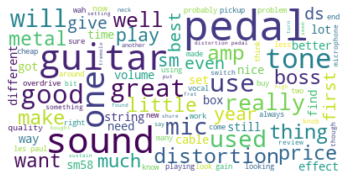

Cluster: 4
reviewText
The primary job of this device is to block the ...
Nice windscreen protects my MXL mic and prevent...
So good that I bought another one.  Love the he...
I have used monster cables for years, and with ...
Perfect for my Epiphone Sheraton II.  Monster c...
Monster makes the best cables and a lifetime wa...
Monster makes a wide array of cables, including...
If you are not use to using a large sustaining ...
I've been using these cables for more than 4 mo...
Fender cords look great and work just as well. ...
Got this cable to run a rockband keyboard contr...
When I was searching for MIDI cables for my ART...
The ends of the midi cable look and feel like q...
Just trying to find a midi to midi was a task, ...
I bought these to go from my board to the amp. ...
Sturdy cord and plugs, inexpensive, good value....
This was exactly what I was after. I have a voi...
I bought these because I really had too long of...
I bought this cord after returning a cheap one ...
Nice soli

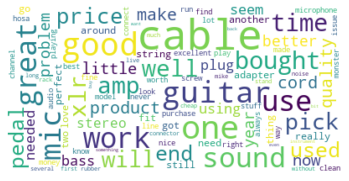

Cluster: 5
reviewText
This item is well built and I like the terminal...
These are Good cables at a good price!! Not sur...
These are great cables. The only con I could gi...
These are great patch cables especially for the...
If they're used for live performances they will...
These cables are a little thin compared to hosa...
They are screws. They screw in and hold things....
Donr be fooled by the imitations... should be t...
These Martin strings (M170) aren't bad. They ju...
These are good for the average guitar player wh...
Martin makes great sounding strings.  I decided...
Strings are not just strings. Guitar strings ar...
I replaced a set of strings that were very used...
The name Martin says it all & has for many,many...
I love these strings, and use them for all of m...
these strings provide a warm crisp tone that ma...
Good strings with good sound.The Extra Light is...
These are okay strings for the Folk Guitar........
I am yet another one of those "Forever Beginner...
I restrun

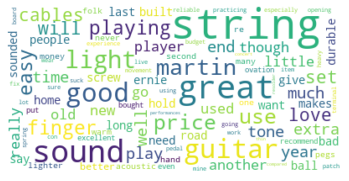

Cluster: 6
reviewText
I now use this cable to run from the output of ...
This Fender cable is the perfect length for me!...
This is a cool looking cheap cable which works ...
The Fender 18 Feet California Clear Instrument ...
Use it every week at gigs.  Solid, no problems ...
This is a fine cable at a decent price point, n...
           Good quality cable and sounds very good
I bought this because I wanted a cheap replacem...
This Hosa Cable is very well made, with good qu...
I didn't expect this cable to be so thin. It's ...
This is good cable. Excellent 1/4&#34; plugs. T...
Pretty crappy cable. It works and gets the job ...
This is a good solid cable with no problems. Wh...
This guitar cable is very nice.  It looks high ...
Hosa Cable GTR210 Guitar Instrument Cable - 10f...
This is your basic, black electric guitar cable...
For the price, fantastic.They do feel light and...
This cable disproves the notion that you get wh...
I was looking for a long cable to perform live ...
This adap

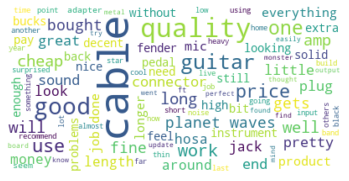

In [24]:
from wordcloud import WordCloud

for k in range(0,true_k):
   s=df_cl[df_cl['labels']==k]
   text=s[column_name__open_responses].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   print('Cluster: {}'.format(k))
   print(column_name__open_responses)
   responses=df_cl[df_cl.labels==k][column_name__open_responses]         
   print(responses.to_string(index=False))
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()
